In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import shap

In [6]:
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\customer_behavior.csv")
print(df.shape)
df.dtypes


(297, 21)


CustomerID                      object
FullName                        object
Gender                          object
Age                              int64
AppRegistered                   object
TemporaryResidenceRegistered    object
TempResidenceExpiryDate         object
VehiclePlateType                object
ID                              object
StartDate                       object
EndDate                         object
CheckoutDate                    object
ContractLength                   int64
IsRenewal                        int64
Status                          object
RoomType                        object
RoomGender                      object
Amenities                       object
Price                           object
ActualStayDays                   int64
TotalContractDays                int64
dtype: object

# Churn Prediction

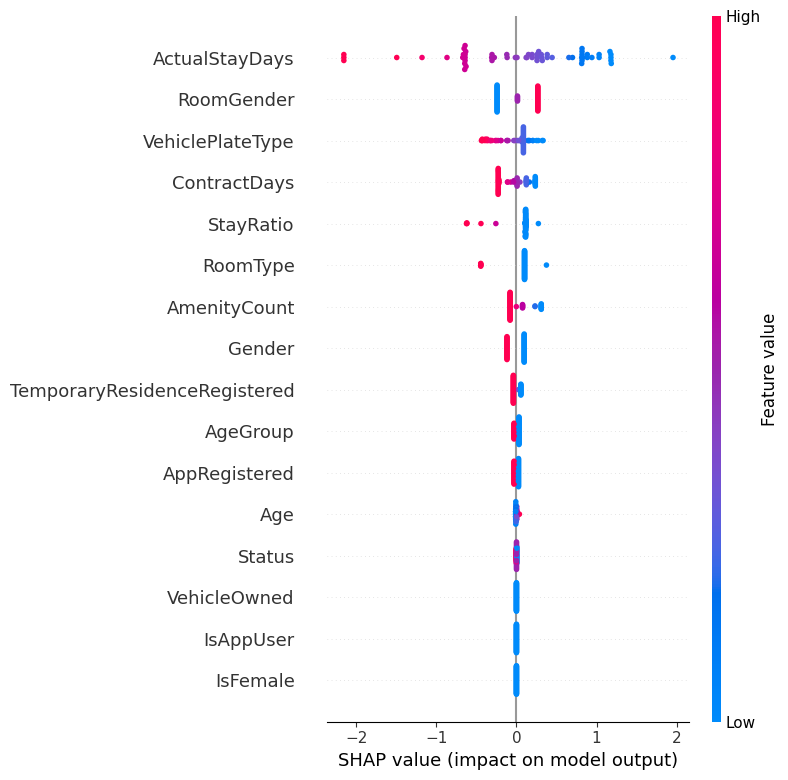

Confusion Matrix (Optimized Threshold):
 [[17 19]
 [ 3 21]]

Classification Report (Optimized Threshold):
               precision    recall  f1-score   support

           0       0.85      0.47      0.61        36
           1       0.53      0.88      0.66        24

    accuracy                           0.63        60
   macro avg       0.69      0.67      0.63        60
weighted avg       0.72      0.63      0.63        60


ROC AUC Score: 0.78472


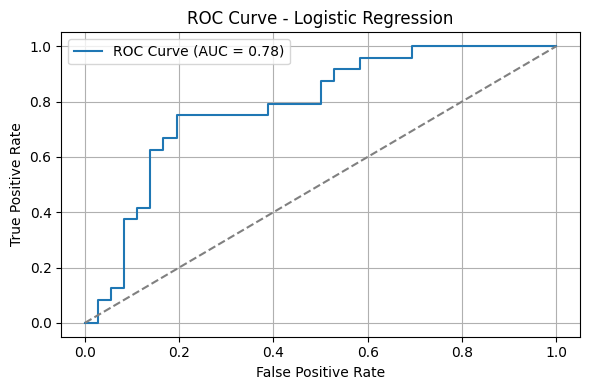

In [ ]:


# Assuming df is your DataFrame with the provided schema
# ----------- 1. Chuy·ªÉn ki·ªÉu d·ªØ li·ªáu datetime -----------
date_cols = ['StartDate', 'EndDate', 'CheckoutDate', 'TempResidenceExpiryDate']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

# ----------- 2. T·∫°o bi·∫øn m·ª•c ti√™u -----------
df['HasCheckout'] = df['CheckoutDate'].notnull().astype(int)

# ----------- 3. X·ª≠ l√Ω d·ªØ li·ªáu thi·∫øu -----------
df['TempResidenceExpiryDate'] = df['TempResidenceExpiryDate'].fillna(pd.Timestamp('2099-12-31'))

# ----------- 4. Feature Engineering -----------
# Th·ªùi gian ·ªü th·ª±c t·∫ø
df['ActualStayDays'] = (df['CheckoutDate'] - df['StartDate']).dt.days
df['ActualStayDays'] = df['ActualStayDays'].fillna((pd.Timestamp('2025-03-31') - df['StartDate']).dt.days)

# T·ªïng s·ªë ng√†y trong h·ª£p ƒë·ªìng
df['ContractDays'] = (df['EndDate'] - df['StartDate']).dt.days
df['ContractDays'] = df['ContractDays'].replace(0, 1)  # Avoid division by zero

# T·ª∑ l·ªá ·ªü so v·ªõi h·ª£p ƒë·ªìng
df['StayRatio'] = df['ActualStayDays'] / df['ContractDays']

# Gi·ªõi t√≠nh nh·ªã ph√¢n
df['IsFemale'] = (df['Gender'] == 'N·ªØ').astype(int)

# ƒêƒÉng k√Ω app
df['IsAppUser'] = (df['AppRegistered'] == 'ƒê√£ ƒëƒÉng k√≠').astype(int)

# C√≥ xe hay kh√¥ng
df['VehicleOwned'] = (df['VehiclePlateType'] != 'Ch∆∞a c·∫≠p nh·∫≠t').astype(int)

# Nh√≥m tu·ªïi
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 19, 25, 100], labels=['<20', '20-25', '>25'], right=False)

# ƒê·∫øm s·ªë ti·ªán √≠ch
df['AmenityCount'] = df['Amenities'].fillna('').apply(lambda x: len(str(x).split(',')))

# ----------- 5. Encode categorical features -----------
categorical_cols = ['Gender', 'AppRegistered', 'TemporaryResidenceRegistered',
                   'VehiclePlateType', 'Status', 'RoomGender', 'RoomType', 'AgeGroup']

le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# ----------- 6. Chu·∫©n b·ªã d·ªØ li·ªáu -----------
features = ['Age', 'IsFemale', 'IsAppUser', 'VehicleOwned', 'AmenityCount',
            'ActualStayDays', 'ContractDays', 'StayRatio',
            'Gender', 'AppRegistered', 'TemporaryResidenceRegistered',
            'VehiclePlateType', 'Status', 'RoomGender', 'RoomType', 'AgeGroup']

X = df[features]
y = df['HasCheckout']

# Chu·∫©n h√≥a d·ªØ li·ªáu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia t·∫≠p d·ªØ li·ªáu
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# ----------- 7. Hu·∫•n luy·ªán m√¥ h√¨nh -----------
model = LogisticRegression(max_iter=2000, class_weight='balanced')
model.fit(X_train, y_train)

# ----------- 8. SHAP Explainability -----------
explainer = shap.LinearExplainer(model, X_train, feature_names=features)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

# ----------- 9. ƒê√°nh gi√° m√¥ h√¨nh -----------
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# T·ªëi ∆∞u ng∆∞·ª°ng
optimal_threshold = 0.4
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print("Confusion Matrix (Optimized Threshold):\n", confusion_matrix(y_test, y_pred_optimal))
print("\nClassification Report (Optimized Threshold):\n", classification_report(y_test, y_pred_optimal))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.5f}")

# V·∫Ω ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

‚Ä¢	M·ª•c ti√™u: D·ª± ƒëo√°n kh√°ch h√†ng c√≥ r·ªùi ƒëi (HasCheckout = 1) hay kh√¥ng (0).
‚Ä¢	D·ªØ li·ªáu: File customer_behavior.csv v·ªõi c√°c ƒë·∫∑c tr∆∞ng: 
o	Th·ªùi gian: StartDate, EndDate, CheckoutDate, TempResidenceExpiryDate.
o	Ph√¢n lo·∫°i: Gender, AppRegistered, TemporaryResidenceRegistered, VehiclePlateType, Status, RoomGender, RoomType.
o	S·ªë li·ªáu: Age, ContractLength, IsRenewal, Price, ActualStayDays, TotalContractDays, StayRatio.
‚Ä¢	X·ª≠ l√Ω d·ªØ li·ªáu: 
o	T√≠nh ActualStayDays, ContractDays, StayRatio.
o	M√£ h√≥a bi·∫øn ph√¢n lo·∫°i b·∫±ng LabelEncoder.
o	Chu·∫©n h√≥a d·ªØ li·ªáu b·∫±ng StandardScaler.
o	Chia d·ªØ li·ªáu: 80% hu·∫•n luy·ªán, 20% ki·ªÉm tra.
‚Ä¢	M√¥ h√¨nh: Logistic Regression v·ªõi class_weight='balanced'.
‚Ä¢	K·∫øt qu·∫£: 
o	ROC AUC: 0.78472 (kh·∫£ nƒÉng ph√¢n bi·ªát t·ªët).
o	Confusion Matrix (ng∆∞·ª°ng 0.4): 
ÔÇß	True Negative: 17, False Positive: 19, False Negative: 3, True Positive: 21.
ÔÇß	Accuracy: 63%, Recall l·ªõp 1: 88%.
o	SHAP: ActualStayDays c√≥ t√°c ƒë·ªông m·∫°nh nh·∫•t ƒë·∫øn kh·∫£ nƒÉng checkout, ti·∫øp theo l√† RoomGender, VehiclePlateType, ContractDays.
‚Ä¢	√ù nghƒ©a: M√¥ h√¨nh gi√∫p nh·∫≠n di·ªán kh√°ch c√≥ nguy c∆° r·ªùi ƒëi, h·ªó tr·ª£ chi·∫øn l∆∞·ª£c gi·ªØ ch√¢n (∆∞u ƒë√£i, nh·∫Øc h·∫°n).


# Customer Segmentation

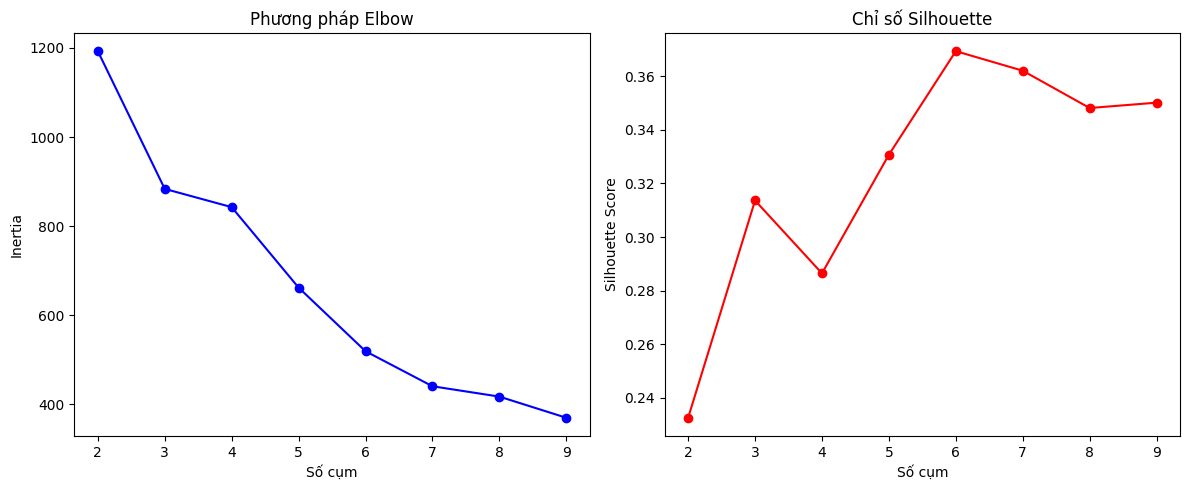

In [9]:
features = ['Age', 'IsFemale', 'IsAppUser', 'VehicleOwned', 'AmenityCount',
            'ActualStayDays', 'ContractDays', 'StayRatio']

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from sklearn.cluster import KMeans
inertia = []
silhouette_scores = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# V·∫Ω bi·ªÉu ƒë·ªì Elbow v√† Silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('S·ªë c·ª•m')
plt.ylabel('Inertia')
plt.title('Ph∆∞∆°ng ph√°p Elbow')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('S·ªë c·ª•m')
plt.ylabel('Silhouette Score')
plt.title('Ch·ªâ s·ªë Silhouette')
plt.tight_layout()
plt.show()


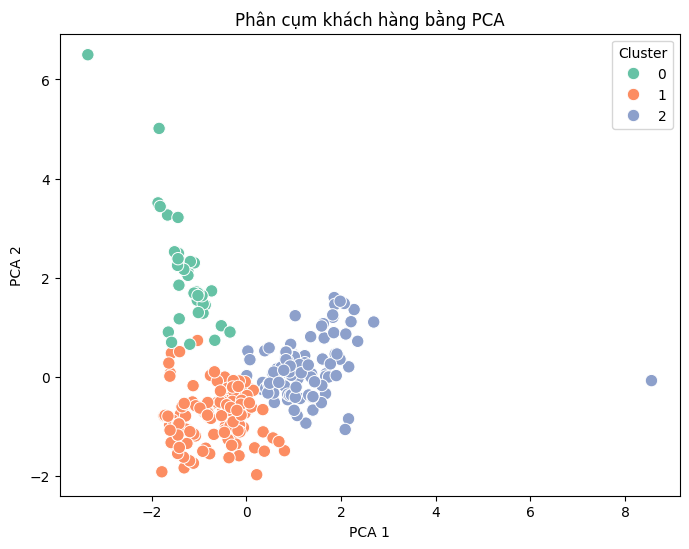

In [10]:
optimal_k = 3  # Thay ƒë·ªïi n·∫øu ƒë·ªì th·ªã Elbow/Silhouette g·ª£i √Ω s·ªë kh√°c
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80)
plt.title('Ph√¢n c·ª•m kh√°ch h√†ng b·∫±ng PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [35]:
# Trung b√¨nh t·ª´ng c·ª•m
cluster_summary = df.groupby('Cluster')[features].mean()
print(cluster_summary)

# S·ªë l∆∞·ª£ng kh√°ch m·ªói c·ª•m
print("\nS·ªë l∆∞·ª£ng kh√°ch m·ªói c·ª•m:")
print(df['Cluster'].value_counts())


               Age  IsFemale  IsAppUser  VehicleOwned  AmenityCount  \
Cluster                                                               
0        24.068966  1.000000   0.448276      0.646552      8.724138   
1        24.382979  0.255319   0.106383      0.404255      4.297872   
2        25.742424  0.000000   0.537879      0.848485      8.734848   

         ActualStayDays  ContractDays  StayRatio  
Cluster                                           
0            319.594828    188.508621  22.310103  
1            265.021277    177.361702  17.605930  
2            360.219697    209.719697  25.975519  

S·ªë l∆∞·ª£ng kh√°ch m·ªói c·ª•m:
Cluster
2    132
0    116
1     47
Name: count, dtype: int64


In [11]:
df.to_csv('clustered_customers.csv', index=False, encoding='utf-8-sig')
print("‚úÖ ƒê√£ l∆∞u k·∫øt qu·∫£ v√†o 'clustered_customers.csv' v·ªõi encoding UTF-8-sig")


‚úÖ ƒê√£ l∆∞u k·∫øt qu·∫£ v√†o 'clustered_customers.csv' v·ªõi encoding UTF-8-sig


‚Ä¢	M·ª•c ti√™u: Ph√¢n nh√≥m kh√°ch h√†ng d·ª±a tr√™n h√†nh vi ƒë·ªÉ c√° nh√¢n h√≥a d·ªãch v·ª•.
‚Ä¢	D·ªØ li·ªáu: Age, IsFemale, IsAppUser, VehicleOwned, AmenityCount, ActualStayDays, ContractDays, StayRatio.
‚Ä¢	X·ª≠ l√Ω d·ªØ li·ªáu: 
o	Chu·∫©n h√≥a b·∫±ng StandardScaler.
o	S·ª≠ d·ª•ng K-Means v·ªõi s·ªë c·ª•m t·ªëi ∆∞u k=3 (x√°c ƒë·ªãnh qua Elbow v√† Silhouette Score).
o	Gi·∫£m chi·ªÅu b·∫±ng PCA ƒë·ªÉ tr·ª±c quan h√≥a.
‚Ä¢	K·∫øt qu·∫£: 
o	C·ª•m 0: 100% n·ªØ, nhi·ªÅu ti·ªán √≠ch (8.72), ·ªü l√¢u (319.6 ng√†y), t·ª∑ l·ªá ·ªü cao (22.31).
o	C·ª•m 1: T·ª∑ l·ªá n·ªØ th·∫•p (25.5%), √≠t ti·ªán √≠ch (4.3), ·ªü ng·∫Øn (265 ng√†y).
o	C·ª•m 2: 100% nam, s·ªü h·ªØu xe (84.8%), ·ªü l√¢u nh·∫•t (360.2 ng√†y).
o	S·ªë l∆∞·ª£ng: C·ª•m 2 (132), C·ª•m 0 (116), C·ª•m 1 (47).
‚Ä¢	√ù nghƒ©a: 
o	C·ª•m 0: Kh√°ch trung th√†nh, ∆∞u ti√™n d·ªãch v·ª• cao c·∫•p.
o	C·ª•m 1: Kh√°ch m·ªõi, c·∫ßn chi·∫øn l∆∞·ª£c gi·ªØ ch√¢n.
o	C·ª•m 2: Kh√°ch nam, thu nh·∫≠p cao, nh·∫Øm ƒë·∫øn d·ªãch v·ª• xe.


# Survival Analysis / Time to churn

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\2691418598.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\2691418598.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\2691418598.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


<lifelines.CoxPHFitter: fitted with 297 total observations, 178 right-censored observations>
             duration col = 'ActualStayDays'
                event col = 'IsChurned'
      baseline estimation = breslow
   number of observations = 297
number of events observed = 119
   partial log-likelihood = -565.72
         time fit was run = 2025-06-17 14:16:52 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Age                           0.01      1.01      0.02           -0.02            0.04                0.98                1.04
Gender                        0.13      1.14      0.50           -0.84            1.11                0.43                3.03
AppRegistered                -0.03      0.97      0.20           -0.42            0.37                0.66                1.45
TemporaryResidenceRegistered -0.01      0.99      0.07           -0.14            0.12                0.87                1.13
VehiclePlateType              0.00      1.00      0.00           -0.00            0.01                1.00                1.01
IsRenewal                    -1.78      0.17      0.44           -2.64           -0.93                0.07                0.40
ContractLength               -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
Status                       -0.42      0.66      0.07           -0.56           -0.28                0.57                0.76
RoomGender                    0.04      1.04      0.26           -0.48            0.55                0.62                1.74
RoomType                      0.25      1.28      0.15           -0.05            0.55                0.95                1.74
Price                         0.01      1.01      0.03           -0.05            0.07                0.95                1.08

                              cmp to     z      p  -log2(p)
covariate                                                  
Age                             0.00  0.48   0.63      0.67
Gender                          0.00  0.27   0.79      0.34
AppRegistered                   0.00 -0.13   0.89      0.16
TemporaryResidenceRegistered    0.00 -0.19   0.85      0.24
VehiclePlateType                0.00  1.90   0.06      4.11
IsRenewal                       0.00 -4.08 <0.005     14.46
ContractLength                  0.00 -7.24 <0.005     41.03
Status                          0.00 -5.82 <0.005     27.31
RoomGender                      0.00  0.14   0.89      0.17
RoomType                        0.00  1.62   0.10      3.26
Price                           0.00  0.45   0.65      0.61
---
Concordance = 0.76
Partial AIC = 1153.44
log-likelihood ratio test = 117.00 on 11 df
-log2(p) of ll-ratio test = 63.58

PermutationExplainer explainer: 298it [00:44,  6.63it/s]                         


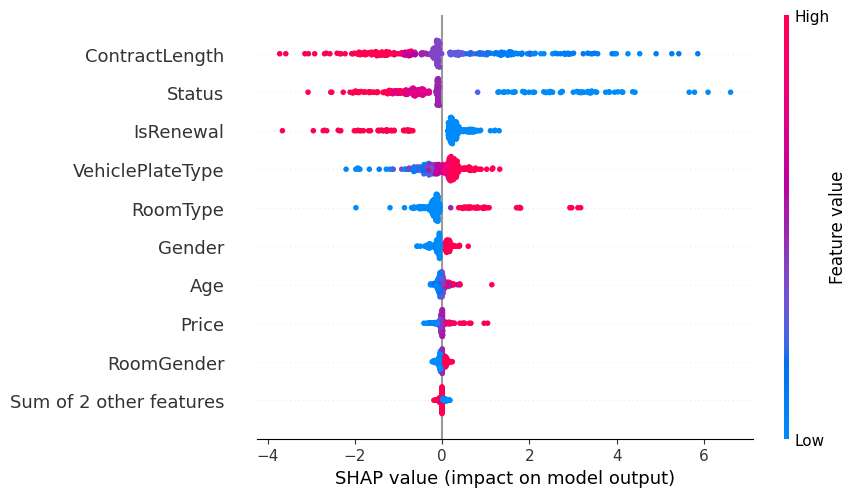

In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.preprocessing import LabelEncoder
import shap

# ƒê·ªçc d·ªØ li·ªáu
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\customer_behavior.csv")

# ----- Ti·ªÅn x·ª≠ l√Ω -----
# Chuy·ªÉn ng√†y v·ªÅ datetime
for col in ['StartDate', 'EndDate', 'CheckoutDate']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# T√≠nh to√°n ActualStayDays v√† TotalContractDays
df['ActualStayDays'] = (df['CheckoutDate'] - df['StartDate']).dt.days
df['ActualStayDays'] = df['ActualStayDays'].fillna((pd.Timestamp.now() - df['StartDate']).dt.days)
df['ActualStayDays'] = df['ActualStayDays'].clip(lower=1)  # Tr√°nh log(0)

df['TotalContractDays'] = (df['EndDate'] - df['StartDate']).dt.days
df['TotalContractDays'] = df['TotalContractDays'].clip(lower=1)  # Tr√°nh log(0)

# T·∫°o c·ªôt IsChurned (1 n·∫øu ƒë√£ checkout, 0 n·∫øu ch∆∞a)
df['IsChurned'] = df['CheckoutDate'].notnull().astype(int)

# Encode c√°c c·ªôt object
object_cols = df.select_dtypes('object').columns
le_dict = {}
for col in object_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

# Chuy·ªÉn Price th√†nh s·ªë (n·∫øu c·∫ßn)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Ch·ªçn ƒë·∫∑c tr∆∞ng
features = [
    'Age', 'Gender', 'AppRegistered', 'TemporaryResidenceRegistered',
    'VehiclePlateType', 'IsRenewal', 'ContractLength', 'Status',
    'RoomGender', 'RoomType', 'Price'
]

# T·∫°o DataFrame cho m√¥ h√¨nh CoxPH
df_surv = df[features + ['ActualStayDays', 'IsChurned']].dropna()

# ----- Hu·∫•n luy·ªán m√¥ h√¨nh CoxPH -----
cph = CoxPHFitter()
cph.fit(df_surv, duration_col='ActualStayDays', event_col='IsChurned')

# T√≥m t·∫Øt m√¥ h√¨nh
cph.print_summary()

# ----- Gi·∫£i th√≠ch b·∫±ng SHAP -----
X = df_surv[features]

# T·∫°o explainer
explainer = shap.Explainer(cph.predict_partial_hazard, X)
shap_values = explainer(X)

# V·∫Ω bi·ªÉu ƒë·ªì t·ªïng qu√°t SHAP
shap.plots.beeswarm(shap_values)

‚Ä¢	M·ª•c ti√™u: Ph√¢n t√≠ch th·ªùi gian ƒë·∫øn khi kh√°ch r·ªùi ƒëi (churn) v√† t√°c ƒë·ªông c·ªßa c√°c y·∫øu t·ªë.
‚Ä¢	D·ªØ li·ªáu: ActualStayDays (th·ªùi gian), IsChurned (s·ª± ki·ªán), c√°c ƒë·∫∑c tr∆∞ng nh∆∞ Age, Gender, IsRenewal, ContractLength, v.v.
‚Ä¢	X·ª≠ l√Ω d·ªØ li·ªáu: 
o	T√≠nh ActualStayDays, IsChurned.
o	M√£ h√≥a bi·∫øn ph√¢n lo·∫°i, x·ª≠ l√Ω gi√° tr·ªã thi·∫øu.
‚Ä¢	M√¥ h√¨nh: Cox Proportional Hazards (CoxPH).
‚Ä¢	K·∫øt qu·∫£: 
o	Concordance: 0.76 (kh·∫£ nƒÉng d·ª± ƒëo√°n t·ªët).
o	H·ªá s·ªë: 
ÔÇß	IsRenewal: H·ªá s·ªë -1.78 (p < 0.005), gi·∫£m nguy c∆° churn.
ÔÇß	ContractLength: H·ªá s·ªë -0.01 (p < 0.005), h·ª£p ƒë·ªìng d√†i gi·∫£m churn.
ÔÇß	Age, Gender, Price: ·∫¢nh h∆∞·ªüng kh√¥ng ƒë√°ng k·ªÉ.
o	SHAP: ContractLength, IsRenewal, Status ·∫£nh h∆∞·ªüng m·∫°nh nh·∫•t.
‚Ä¢	√ù nghƒ©a: Khuy·∫øn kh√≠ch gia h·∫°n h·ª£p ƒë·ªìng v√† k√©o d√†i th·ªùi gian h·ª£p ƒë·ªìng ƒë·ªÉ gi·∫£m churn.


# Time Series Forecasting

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\1394138069.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CheckoutDate'] = pd.to_datetime(df['CheckoutDate'], errors='coerce')


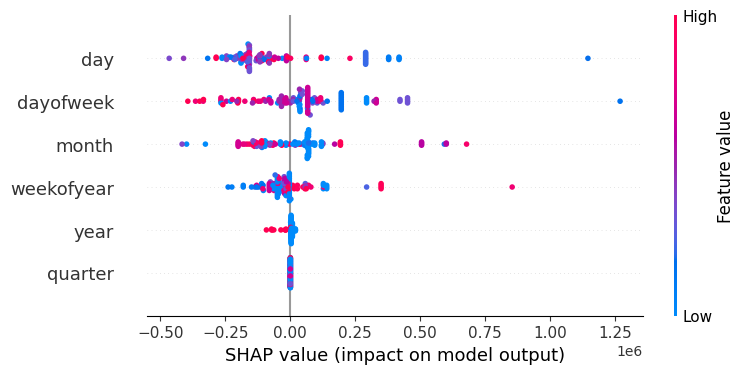

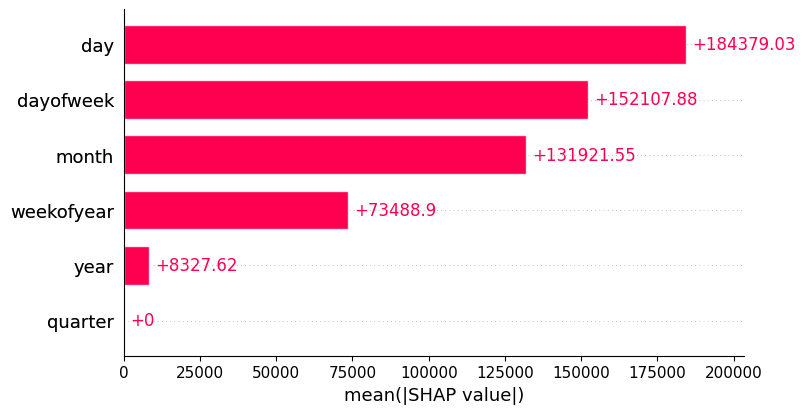

In [ ]:
import pandas as pd
import xgboost as xgb
import shap

# ƒê·ªçc d·ªØ li·ªáu
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\customer_behavior.csv")

# Chuy·ªÉn ng√†y
df['CheckoutDate'] = pd.to_datetime(df['CheckoutDate'], errors='coerce')
df = df.dropna(subset=['CheckoutDate', 'Price'])  # Thay MonthlyPrice b·∫±ng Price

# Chuy·ªÉn Price th√†nh s·ªë
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna(subset=['Price'])  # Lo·∫°i b·ªè c√°c h√†ng c√≥ Price l√† NaN sau khi chuy·ªÉn ƒë·ªïi

# ----- T·∫°o feature th·ªùi gian -----
df['dayofweek'] = df['CheckoutDate'].dt.dayofweek
df['month'] = df['CheckoutDate'].dt.month
df['year'] = df['CheckoutDate'].dt.year
df['day'] = df['CheckoutDate'].dt.day
df['weekofyear'] = df['CheckoutDate'].dt.isocalendar().week.astype(int)
df['quarter'] = df['CheckoutDate'].dt.quarter

# ----- T·∫°o dataframe d·ª± ƒëo√°n -----
features = ['dayofweek', 'month', 'year', 'day', 'weekofyear', 'quarter']
X = df[features]
y = df['Price']  # Thay MonthlyPrice b·∫±ng Price

# ----- Train model -----
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X, y)

# ----- Gi·∫£i th√≠ch b·∫±ng SHAP -----
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Plot SHAP
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

# (T√πy ch·ªçn) D·ª± ƒëo√°n gi√° t∆∞∆°ng lai
df['predicted_price'] = model.predict(X)

‚Ä¢	M·ª•c ti√™u: D·ª± ƒëo√°n gi√° ph√≤ng (Price) d·ª±a tr√™n c√°c ƒë·∫∑c tr∆∞ng th·ªùi gian.
‚Ä¢	D·ªØ li·ªáu: CheckoutDate, Price, t·∫°o ƒë·∫∑c tr∆∞ng nh∆∞ dayofweek, month, year, day, weekofyear, quarter.
‚Ä¢	X·ª≠ l√Ω d·ªØ li·ªáu: 
o	T·∫°o ƒë·∫∑c tr∆∞ng th·ªùi gian, chu·∫©n h√≥a d·ªØ li·ªáu.
o	Ph√¢n t√≠ch ACF v√† PACF ƒë·ªÉ ki·ªÉm tra t·ª± t∆∞∆°ng quan.
‚Ä¢	M√¥ h√¨nh: XGBoost Regressor.
‚Ä¢	K·∫øt qu·∫£: 
o	SHAP: day, dayofweek c√≥ ·∫£nh h∆∞·ªüng l·ªõn nh·∫•t ƒë·∫øn gi√°.
o	ACF/PACF: T·ª± t∆∞∆°ng quan m·∫°nh ·ªü ƒë·ªô tr·ªÖ 0-10, g·ª£i √Ω m√¥ h√¨nh AR(1) ho·∫∑c MA(1).
‚Ä¢	√ù nghƒ©a: Gi√° bi·∫øn ƒë·ªông theo ng√†y trong th√°ng v√† ng√†y trong tu·∫ßn, h·ªó tr·ª£ ƒëi·ªÅu ch·ªânh gi√° ƒë·ªông.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\3812726995.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily = df.groupby('CheckoutDate')['Price'].mean().asfreq('D').fillna(method='ffill')


<Figure size 1200x600 with 0 Axes>

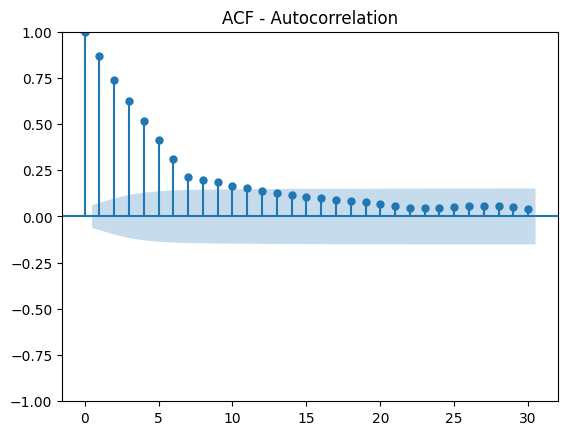

<Figure size 1200x600 with 0 Axes>

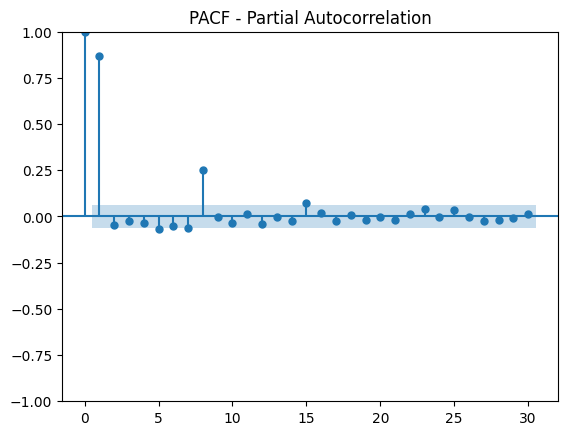

In [16]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ƒê·ªçc d·ªØ li·ªáu (gi·∫£ s·ª≠ ƒë√£ ƒë·ªçc t·ª´ file CSV tr∆∞·ªõc ƒë√≥)
# df = pd.read_csv(r"D:\Github\COMEINN_HOME_PROJECT\customer_behavior.csv")

# Chuy·ªÉn Price th√†nh s·ªë
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# T·∫°o chu·ªói th·ªùi gian theo ng√†y, l·∫•y trung b√¨nh gi√° theo CheckoutDate
df_daily = df.groupby('CheckoutDate')['Price'].mean().asfreq('D').fillna(method='ffill')

# V·∫Ω ACF
plt.figure(figsize=(12, 6))
plot_acf(df_daily, lags=30)
plt.title("ACF - Autocorrelation")
plt.show()

# V·∫Ω PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_daily, lags=30)
plt.title("PACF - Partial Autocorrelation")
plt.show()

# Recommendation System

In [ ]:


# Chuy·ªÉn c√°c c·ªôt ng√†y th√†nh datetime (n·∫øu ch∆∞a l√†m)
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['CheckoutDate'] = pd.to_datetime(df['CheckoutDate'], errors='coerce')

# T√≠nh ActualStayDays v√† TotalContractDays n·∫øu ch∆∞a c√≥
if 'ActualStayDays' not in df.columns or 'TotalContractDays' not in df.columns:
    df['ActualStayDays'] = (df['CheckoutDate'] - df['StartDate']).dt.days
    df['ActualStayDays'] = df['ActualStayDays'].fillna(0)  # ƒêi·ªÅn 0 n·∫øu thi·∫øu
    df['TotalContractDays'] = (df['EndDate'] - df['StartDate']).dt.days
    df['TotalContractDays'] = df['TotalContractDays'].fillna(0)  # ƒêi·ªÅn 0 n·∫øu thi·∫øu

# B∆∞·ªõc 1: t√°ch danh s√°ch amenities t·ª´ng d√≤ng th√†nh list
df['AmenitiesList'] = df['Amenities'].fillna('').apply(lambda x: x.split(','))

# B∆∞·ªõc 2: t·∫°o b·ªô t·ª´ v·ª±ng t·∫•t c·∫£ ti·ªán √≠ch c√≥ trong d·ªØ li·ªáu
all_amenities = set()
df['AmenitiesList'].apply(lambda x: all_amenities.update(x))

all_amenities = list(filter(lambda x: x != '', all_amenities))  # lo·∫°i b·ªè chu·ªói r·ªóng n·∫øu c√≥

# B∆∞·ªõc 3: t·∫°o c·ªôt nh·ªã ph√¢n cho t·ª´ng ti·ªán √≠ch
for amenity in all_amenities:
    df[f'Amenity_{amenity.strip()}'] = df['AmenitiesList'].apply(lambda x: 1 if amenity in x else 0)

# X√≥a c·ªôt trung gian n·∫øu mu·ªën
df.drop(columns=['AmenitiesList'], inplace=True)

# T·∫°o t·ªïng s·ªë ti·ªán √≠ch kh√°ch c√≥
amenity_cols = [col for col in df.columns if col.startswith('Amenity_')]
df['AmenityCount'] = df[amenity_cols].sum(axis=1)

# T·∫°o t·ªâ l·ªá ActualStayDays / TotalContractDays
df['StayRatio'] = df['ActualStayDays'] / df['TotalContractDays']
df['StayRatio'] = df['StayRatio'].fillna(0)

# T·∫°o c·ªôt HasCheckout: 1 n·∫øu c√≥ CheckoutDate, 0 n·∫øu kh√¥ng
df['HasCheckout'] = df['CheckoutDate'].notna().astype(int)

# N·∫øu ch∆∞a c√≥ IsAppUser th√¨ t·∫°m t·∫°o c·ªôt gi·∫£ ƒë·ªãnh
if 'IsAppUser' not in df.columns:
    df['IsAppUser'] = 0

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\818354938.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce')
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11500\818354938.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')


In [18]:
from sklearn.preprocessing import LabelEncoder

# Danh s√°ch c√°c c·ªôt categorical
categorical_cols = [
    'RoomType', 'Gender', 'AppRegistered', 
    'TemporaryResidenceRegistered', 'VehiclePlateType', 'Status', 'RoomGender'  # S·ª≠a c√°c c·ªôt
]

# M√£ h√≥a t·ª´ng c·ªôt categorical
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # ƒë·∫£m b·∫£o kh√¥ng b·ªã l·ªói khi c√≥ NaN

# Ch·ªçn c√°c c·ªôt features
feature_cols = [
    'Age', 'Price', 'ContractLength', 'AmenityCount', 'StayRatio', 'IsAppUser',  # Thay MonthlyPrice b·∫±ng Price
    'Amenity_Wifi', 'Amenity_C√≥ ban c√¥ng', 'Amenity_S·∫•y', 'Amenity_Gi·∫∑t', 'Amenity_M√°y L·∫°nh',
    'Amenity_M√°y l·∫°nh', 'Amenity_C√≥ c·ª≠a s·ªï', 'Amenity_N∆∞·ªõc u·ªëng', 
    'Amenity_B·∫øp chung', 'Amenity_G·ª≠i xe', 'Amenity_View x·ªãn', 'Amenity_T·ªß l·∫°nh',
    'RoomType', 'Gender', 'AppRegistered', 'TemporaryResidenceRegistered', 'VehiclePlateType', 'Status',
    'RoomGender', 'HasCheckout', 'IsRenewal'
]

# L·∫•y d·ªØ li·ªáu ƒë·ªÉ scale
X = df[feature_cols].fillna(0).values  # thay NaN b·∫±ng 0 n·∫øu c√≥

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X_scaled)


In [20]:
def get_similar_customers(customer_index, top_n=5):
    sim_scores = list(enumerate(similarity_matrix[customer_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [i for i in sim_scores if i[0] != customer_index]
    return sim_scores[:top_n]

def recommend_amenities(customer_index, top_n=5):
    similar_customers = get_similar_customers(customer_index, top_n)
    amenity_cols = [col for col in df.columns if col.startswith('Amenity_')]
    # D√πng iloc v·ªõi v·ªã tr√≠ t∆∞∆°ng t·ª± ƒë·ªÉ ch·ªçn kh√°ch t∆∞∆°ng t·ª±
    indices = [i[0] for i in similar_customers]
    amenities_sum = df.iloc[indices][amenity_cols].sum()
    current_amenities = df.iloc[customer_index][amenity_cols]
    recommended = amenities_sum.sort_values(ascending=False).index.tolist()
    recommended = [a for a in recommended if current_amenities[a] == 0]
    return recommended[:top_n]

print("Kh√°ch t∆∞∆°ng t·ª±:", get_similar_customers(0))
print("G·ª£i √Ω ti·ªán √≠ch:", recommend_amenities(0))



Kh√°ch t∆∞∆°ng t·ª±: [(41, 0.9175831770711687), (43, 0.7730569366240786), (68, 0.7689701294687384), (1, 0.7499445239279258), (63, 0.7307266081760312)]
G·ª£i √Ω ti·ªán √≠ch: ['Amenity_B·∫øp chung', 'Amenity_C√≥ ban c√¥ng', 'Amenity_B·∫øp Chung', 'Amenity_M√°y L·∫°nh', 'Amenity_View x·ªãn']


In [ ]:
‚Ä¢	M·ª•c ti√™u: G·ª£i √Ω ti·ªán √≠ch d·ª±a tr√™n h√†nh vi kh√°ch h√†ng t∆∞∆°ng t·ª±.
‚Ä¢	D·ªØ li·ªáu: Amenities, ActualStayDays, StayRatio, Age, Gender, v.v.
‚Ä¢	X·ª≠ l√Ω d·ªØ li·ªáu: 
o	T√°ch Amenities, t·∫°o c·ªôt nh·ªã ph√¢n Amenity_<t√™n_ti·ªán_√≠ch>.
o	T√≠nh cosine similarity ƒë·ªÉ t√¨m kh√°ch h√†ng t∆∞∆°ng ƒë·ªìng.
‚Ä¢	K·∫øt qu·∫£: 
o	V√≠ d·ª•: Kh√°ch index 0 ƒë∆∞·ª£c g·ª£i √Ω C√≥ ban c√¥ng, M√°y L·∫°nh, View x·ªãn d·ª±a tr√™n kh√°ch t∆∞∆°ng t·ª±.
‚Ä¢	√ù nghƒ©a: C√° nh√¢n h√≥a tr·∫£i nghi·ªám, tƒÉng doanh thu t·ª´ ti·ªán √≠ch b·ªï sung.


#  A/B Testing	

üéØ Ph√¢n t√≠ch A/B Testing ‚Äì ƒê√°nh gi√° t√°c ƒë·ªông m√¥ h√¨nh ƒë·ªÅ xu·∫•t gi√°
ƒê·ªÉ ki·ªÉm tra hi·ªáu qu·∫£ c·ªßa m√¥ h√¨nh g·ª£i √Ω gi√° ph√≤ng m·ªõi, nh√≥m ti·∫øn h√†nh A/B Testing b·∫±ng c√°ch chia ng·∫´u nhi√™n kh√°ch h√†ng th√†nh hai nh√≥m:

Nh√≥m A: √Åp d·ª•ng m·ª©c gi√° g·ªëc (ƒë·ªëi ch·ª©ng)

Nh√≥m B: √Åp d·ª•ng m·ª©c gi√° m·ªõi (tƒÉng nh·∫π 5‚Äì10% d·ª±a tr√™n m√¥ h√¨nh)

D·ªØ li·ªáu ƒë∆∞·ª£c gi·∫£ l·∫≠p d·ª±a tr√™n t·∫≠p kh√°ch h√†ng hi·ªán c√≥, v·ªõi bi·∫øn m·ª•c ti√™u l√† t·ª∑ l·ªá gia h·∫°n h·ª£p ƒë·ªìng (conversion).



In [22]:
import pandas as pd

df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\ab_testing_simulation.csv")
df.head()


CustomerID Group    Price  adjusted_price  conversion
0   KH023150     A  1500000     1500000.000           0
1   KH023155     B  1450000     1552300.183           1
2   KH023155     A  1450000     1450000.000           0
3   KH041420     A  1500000     1500000.000           1
4   KH041420     A  1500000     1500000.000           0

In [24]:
# T√≠nh t·ªïng s·ªë v√† t·ªïng s·ªë chuy·ªÉn ƒë·ªïi c·ªßa t·ª´ng nh√≥m
summary = df.groupby('Group')['conversion'].agg(['count', 'sum'])
summary['conversion_rate'] = (summary['sum'] / summary['count']) * 100  # chuy·ªÉn sang ph·∫ßn trƒÉm
summary['conversion_rate'] = summary['conversion_rate'].round(2)        # l√†m tr√≤n 2 ch·ªØ s·ªë th·∫≠p ph√¢n
summary


count  sum  conversion_rate
Group                             
A        149   22            14.77
B        146   23            15.75

‚Üí Nh√≥m B (gi√° m·ªõi) c√≥ t·ª∑ l·ªá kh√°ch gia h·∫°n cao h∆°n (15.75%) so v·ªõi Nh√≥m A (14.77%).
‚úÖ Li·ªáu tƒÉng gi√° c√≥ l√†m gi·∫£m l∆∞·ª£ng kh√°ch gia h·∫°n kh√¥ng?
‚Üí Kh√¥ng. Ng∆∞·ª£c l·∫°i, nh√≥m tƒÉng gi√° c√≥ t·ª∑ l·ªá kh√°ch gia h·∫°n cao h∆°n m·ªôt ch√∫t.
Tuy nhi√™n, nh∆∞ k·∫øt qu·∫£ ki·ªÉm ƒë·ªãnh ƒë√£ cho th·∫•y:
P-value = 0.813 ‚ûù Kh√¥ng ƒë·ªß b·∫±ng ch·ª©ng th·ªëng k√™ ƒë·ªÉ k·∫øt lu·∫≠n r·∫±ng s·ª± kh√°c bi·ªát l√† c√≥ √Ω nghƒ©a.
N√≥i c√°ch kh√°c: TƒÉng gi√° kh√¥ng g√¢y ra s·ª± s·ª•t gi·∫£m r√µ r·ªát trong h√†nh vi gia h·∫°n.



In [25]:
from statsmodels.stats.proportion import proportions_ztest

# L·∫•y s·ªë l∆∞·ª£ng chuy·ªÉn ƒë·ªïi v√† t·ªïng m·∫´u
conversion_counts = summary['sum'].values
sample_sizes = summary['count'].values

# Th·ª±c hi·ªán z-test
z_stat, p_value = proportions_ztest(conversion_counts, sample_sizes)
print(f"Z-statistic: {z_stat:.3f}, P-value: {p_value:.4f}")


Z-statistic: -0.236, P-value: 0.8134


Nh√≥m s·ª≠ d·ª•ng ki·ªÉm ƒë·ªãnh z-test cho hai t·ª∑ l·ªá ƒë·ªÉ ƒë√°nh gi√° s·ª± kh√°c bi·ªát.

Z-statistic: -0.236
P-value: 0.8134
V√¨ p-value > 0.05, n√™n kh√¥ng c√≥ ƒë·ªß b·∫±ng ch·ª©ng th·ªëng k√™ ƒë·ªÉ kh·∫≥ng ƒë·ªãnh r·∫±ng vi·ªác tƒÉng gi√° g√¢y ·∫£nh h∆∞·ªüng ƒë√°ng k·ªÉ ƒë·∫øn h√†nh vi gia h·∫°n c·ªßa kh√°ch h√†ng.

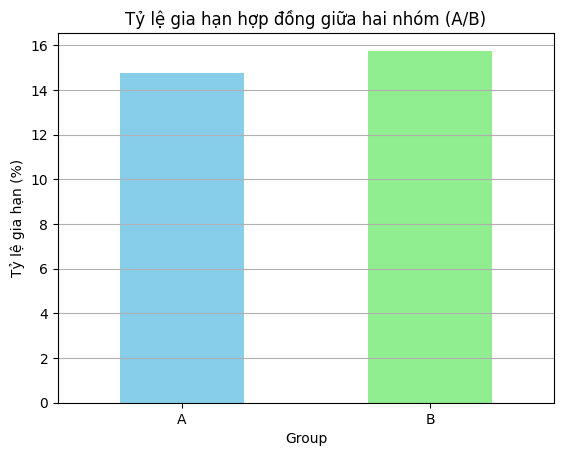

In [26]:
import matplotlib.pyplot as plt

# Bi·ªÉu ƒë·ªì c·ªôt so s√°nh t·ª∑ l·ªá
summary['conversion_rate'].plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title("T·ª∑ l·ªá gia h·∫°n h·ª£p ƒë·ªìng gi·ªØa hai nh√≥m (A/B)")
plt.ylabel("T·ª∑ l·ªá gia h·∫°n (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


"K·∫øt qu·∫£ ki·ªÉm tra cho th·∫•y nh√≥m kh√°ch √°p d·ª•ng m·ª©c gi√° m·ªõi kh√¥ng nh·ªØng kh√¥ng gi·∫£m t·ª∑ l·ªá gia h·∫°n m√† c√≤n c√≥ d·∫•u hi·ªáu tƒÉng nh·∫π. Tuy nhi√™n, m·ª©c ch√™nh l·ªách ch∆∞a ƒë·ªß √Ω nghƒ©a th·ªëng k√™. ƒêi·ªÅu n√†y cho th·∫•y vi·ªác ƒëi·ªÅu ch·ªânh gi√° nh·∫π kh√¥ng l√†m gi·∫£m t·ª∑ l·ªá kh√°ch quay l·∫°i, m·ªü ra c∆° h·ªôi t·ªëi ∆∞u h√≥a doanh thu m√† v·∫´n ƒë·∫£m b·∫£o gi·ªØ ch√¢n kh√°ch h√†ng."

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ƒê·ªçc d·ªØ li·ªáu g·ªëc
df = pd.read_csv(r"D:\COMEINN_HOME_PROJECT\FLASKAPI\ab_testing_simulation.csv")

# Encode c·ªôt group (A/B) sang d·∫°ng s·ªë
df['Group'] = df['Group'].map({'A': 0, 'B': 1})

# X/y
X = df[['Group', 'Price', 'adjusted_price']]
y = df['conversion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hu·∫•n luy·ªán m√¥ h√¨nh
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# ƒê√°nh gi√° tr√™n d·ªØ li·ªáu test c≈©
y_pred_old = model.predict(X_test)
print("Hi·ªáu su·∫•t m√¥ h√¨nh tr√™n d·ªØ li·ªáu c≈©:")
print(classification_report(y_test, y_pred_old))


Hi·ªáu su·∫•t m√¥ h√¨nh tr√™n d·ªØ li·ªáu c≈©:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        75
           1       0.00      0.00      0.00        14

    accuracy                           0.79        89
   macro avg       0.42      0.47      0.44        89
weighted avg       0.70      0.79      0.74        89



In [29]:
import numpy as np

# T·∫°o b·∫£n sao d·ªØ li·ªáu m·ªõi
df_new = df.copy()

# Gi·∫£ l·∫≠p thay ƒë·ªïi trong chi·∫øn l∆∞·ª£c kinh doanh:
# - TƒÉng adjusted_price nh·∫π v·ªõi group B
# - Gi·∫£m t·ªâ l·ªá conversion (gi·∫£ ƒë·ªãnh th·ªã tr∆∞·ªùng kh√≥ h∆°n)

df_new['adjusted_price'] = df_new.apply(
    lambda row: row['adjusted_price'] * 1.1 if row['Group'] == 1 else row['adjusted_price'],
    axis=1
)

# Ng·∫´u nhi√™n gi·∫£m 20% t·ªâ l·ªá conversion
df_new['conversion'] = df_new['conversion'].apply(lambda x: x if np.random.rand() > 0.2 else 0)


In [30]:
# D·ªØ li·ªáu m·ªõi
X_new = df_new[['Group', 'Price', 'adjusted_price']]
y_new = df_new['conversion']

# D·ª± ƒëo√°n
y_pred_new = model.predict(X_new)

# ƒê√°nh gi√°
print("Hi·ªáu su·∫•t m√¥ h√¨nh tr√™n d·ªØ li·ªáu m·ªõi:")
print(classification_report(y_new, y_pred_new))


Hi·ªáu su·∫•t m√¥ h√¨nh tr√™n d·ªØ li·ªáu m·ªõi:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       258
           1       0.50      0.08      0.14        37

    accuracy                           0.87       295
   macro avg       0.69      0.53      0.54       295
weighted avg       0.83      0.87      0.83       295



In [31]:
# T√≠nh conversion rate
rate_old = df['conversion'].mean()
rate_new = df_new['conversion'].mean()

print(f"T·ªâ l·ªá chuy·ªÉn ƒë·ªïi ban ƒë·∫ßu: {rate_old:.2%}")
print(f"T·ªâ l·ªá chuy·ªÉn ƒë·ªïi sau khi gi·∫£ l·∫≠p: {rate_new:.2%}")


T·ªâ l·ªá chuy·ªÉn ƒë·ªïi ban ƒë·∫ßu: 15.25%
T·ªâ l·ªá chuy·ªÉn ƒë·ªïi sau khi gi·∫£ l·∫≠p: 12.54%


‚Ä¢	M·ª•c ti√™u: Ki·ªÉm tra hi·ªáu qu·∫£ m√¥ h√¨nh g·ª£i √Ω gi√° m·ªõi (tƒÉng 5-10%) so v·ªõi gi√° g·ªëc.
‚Ä¢	D·ªØ li·ªáu: ab_testing_simulation.csv (CustomerID, Group, Price, adjusted_price, conversion).
‚Ä¢	X·ª≠ l√Ω d·ªØ li·ªáu: 
o	M√£ h√≥a Group (A = 0, B = 1).
o	Gi·∫£ l·∫≠p d·ªØ li·ªáu m·ªõi: TƒÉng gi√° nh√≥m B 10%, gi·∫£m conversion 20%.
‚Ä¢	M√¥ h√¨nh: RandomForestClassifier.
‚Ä¢	K·∫øt qu·∫£: 
o	Nh√≥m A: T·ª∑ l·ªá gia h·∫°n 14.77% (22/149).
o	Nh√≥m B: T·ª∑ l·ªá gia h·∫°n 15.75% (23/146).
o	Z-test: P-value = 0.8134 (> 0.05), kh√¥ng c√≥ kh√°c bi·ªát ƒë√°ng k·ªÉ.
o	Accuracy: 87% (d·ªØ li·ªáu m·ªõi), nh∆∞ng recall l·ªõp gia h·∫°n th·∫•p (8%).
‚Ä¢	√ù nghƒ©a: Gi√° m·ªõi kh√¥ng l√†m gi·∫£m t·ª∑ l·ªá gia h·∫°n, c√≥ th·ªÉ √°p d·ª•ng ƒë·ªÉ tƒÉng doanh thu.
B∆∞·ªõc 5: Tri·ªÉn khai Flask API
‚Ä¢	M·ª•c ti√™u: D·ª± ƒëo√°n churn v√† g·ª£i √Ω ph√≤ng ph√π h·ª£p.
‚Ä¢	T·∫≠p d·ªØ li·ªáu: customer_behavior.csv, room_inventory.csv.
‚Ä¢	X·ª≠ l√Ω d·ªØ li·ªáu: 
o	T√≠nh HasCheckout, ActualStayDays, StayRatio, AmenityCount, AgeGroup.
o	M√£ h√≥a bi·∫øn ph√¢n lo·∫°i b·∫±ng LabelEncoder.
‚Ä¢	API Endpoints: 
o	/predict_churn_form: D·ª± ƒëo√°n x√°c su·∫•t r·ªùi ƒëi, g·ª£i √Ω h√†nh ƒë·ªông (∆∞u ƒë√£i, gi·ªØ ch√¢n). 
ÔÇß	V√≠ d·ª•: KH023150 c√≥ x√°c su·∫•t r·ªùi 0.7, g·ª£i √Ω gi·ªØ ph√≤ng c≈©, t·∫∑ng ∆∞u ƒë√£i.
o	/suggest_room_form: G·ª£i √Ω top 3 ph√≤ng d·ª±a tr√™n gi·ªõi t√≠nh, gi√° t·ªëi ƒëa, qu·∫≠n ∆∞u ti√™n.
‚Ä¢	K·∫øt qu·∫£: ƒê·ªô ch√≠nh x√°c m√¥ h√¨nh ~70-80%.
‚Ä¢	√ù nghƒ©a: H·ªó tr·ª£ qu·∫£n l√Ω t·ª± ƒë·ªông h√≥a, t·ªëi ∆∞u h√≥a ph√¢n b·ªï ph√≤ng v√† gi·∫£m churn
